In [1]:
# Imports
import sys
sys.path.append('../Classes')
from flight_physics import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
from mpl_toolkits import mplot3d
import numpy as np
import math

### Hamilton-Jacobi PDE Residual
$ G(x,t,p) = \frac {\partial \hat{V}_p (x,t)} {\partial t} + \min \{ 0, \sup_{u \in U} \frac {\partial \hat{V}_p (x,t)} {\partial x} f(x, u) \} $ \
$ \hat{V}_p (x, T) = l(x) $

In [2]:
# Network residuals
def G(x, t, Vp):
    x.requires_grad = True
    t.requires_grad = True

    y = Vp(x, t)

    y_x = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
    retain_graph=True,
    create_graph=True,
    allow_unused=True)[0]

    y_t = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y),
    retain_graph=True,
    create_graph=True,
    allow_unused=True)[0]

    # correct controls?
    
    dot = torch.sum(y_x * f(x, u(x)), -1) # better function to use for dot product
    out = y_t - nn.functional.relu( - dot )

    return out

# Cost criterion
T = 2.5 # import this?
def H(x, t, Vp):
    return torch.sum(G(x, t, Vp) ** 2)

def loss(x, t, Vp):
    df_loss = H(x, t, Vp)
    tz = T * torch.ones(t.size())
    dg_loss = torch.sum((Vp(x,tz) - l(x)) ** 2)
    loss_ = df_loss + dg_loss
    return loss_, df_loss, dg_loss

### Approximation Function

In [48]:
class ValueFunction(nn.Module):
    def __init__(self,input_size=3,output_size=1):
        super(ValueFunction, self).__init__()
        self.linear1 = nn.Linear(input_size,5)
        self.linear2 = nn.Linear(5,5)
        self.linear3 = nn.Linear(5,output_size)

    def forward(self,x,t):
        inp = torch.cat((x, t.unsqueeze(-1)), -1)
        z = torch.sigmoid(self.linear1(inp))
        z = torch.sigmoid(self.linear2(z))
        z = torch.tanh(self.linear3(z))
        return z.squeeze()

valueApprox = ValueFunction()

### Value Function Visualization

In [12]:
xi = torch.load("../Data/xi_roi.pt")
ti = torch.load("../Data/ti_roi.pt")

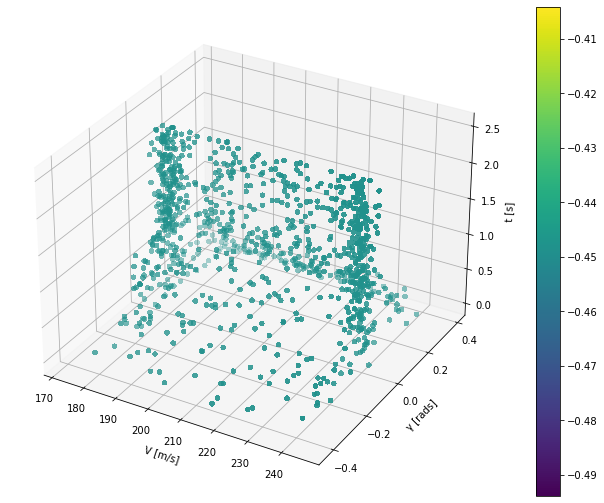

In [49]:
# Creating figure
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot

cc = valueApprox(xi, ti).detach().numpy()
surf = ax.scatter(xi[:,0], xi[:,1], ti, c = cc, linewidth=0, antialiased=False)
ax.set(xlabel="V [m/s]", ylabel="\u03B3 [rads]", zlabel="t [s]")

fig.colorbar(surf)
plt.show()